## Ejercicio 2: Vision transformer

In [1]:
! pip install timm

     |████████████████████████████████| 376 kB 5.5 MB/s 


In [2]:
import numpy as np
import PIL
import timm.models.vision_transformer as timm
import torch
import torch.nn as nn

In [3]:
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2021-10-08 17:03:49--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2021-10-08 17:03:49 (76.9 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



In [4]:
class OneClassVit(nn.Module):
    """
    Simple Wrapper around a potentially pretrained image VIT classifier on imagenet:
    - handles the resizing of the inputs
    - handles the adaptation of the output size
    """

    def __init__(self, image_size=384):
        super().__init__()
        if image_size != 384:
            self.interpolate = nn.Upsample(size=(384, 384))
        else:
            self.interpolate = nn.Identity()
        self.core_vit = timm.vit_base_patch32_384(pretrained=True)

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        :param x: tensor of shape (batch_size, 3, height, width)
        :return shape (batch_size, embedding_size, seq_len)
        """
        image = self.interpolate(image)
        outputs = self.vit_encoding(self.core_vit, image)

        return outputs


    def vit_encoding(self, vit, x):
        """
        Adaptation of the implementation of the timm.VisionTransformer.forward_feature
        to extract the representation at several level
        """
        batch_size = x.shape[0]
        x = vit.patch_embed(x)  # embed patches
        cls_tokens = vit.cls_token.expand(batch_size, -1, -1)  # create class token
        x = torch.cat((cls_tokens, x), dim=1)  # concatenate class token to patch embeddings

        x = x + vit.pos_embed  # sum positional embeddings to patch and class token embeddings
        x = vit.pos_drop(x)  # apply dropout

        for i, blk in enumerate(vit.blocks):  # iterate over VIT encoder blocks
            x = blk(x)

        x = vit.norm(x)  # apply normalization
        x = x[:, 0]  # take class token embedding
        x = vit.head(x)  # feed it to classifier
        return x

--2021-10-08 17:05:15--  https://picsum.photos/384
Resolving picsum.photos (picsum.photos)... 172.67.74.163, 104.26.4.30, 104.26.5.30, ...
Connecting to picsum.photos (picsum.photos)|172.67.74.163|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://i.picsum.photos/id/377/384/384.jpg?hmac=5N2-fOubgQGvxuh7G1e_vMyqtSZzOBLD9HntXO7Rltk [following]
--2021-10-08 17:05:15--  https://i.picsum.photos/id/377/384/384.jpg?hmac=5N2-fOubgQGvxuh7G1e_vMyqtSZzOBLD9HntXO7Rltk
Resolving i.picsum.photos (i.picsum.photos)... 104.26.4.30, 104.26.5.30, 172.67.74.163, ...
Connecting to i.picsum.photos (i.picsum.photos)|104.26.4.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg              [ <=>                ]  10.86K  --.-KB/s    in 0s      

2021-10-08 17:05:16 (54.0 MB/s) - ‘picsum.jpg’ saved [11116]



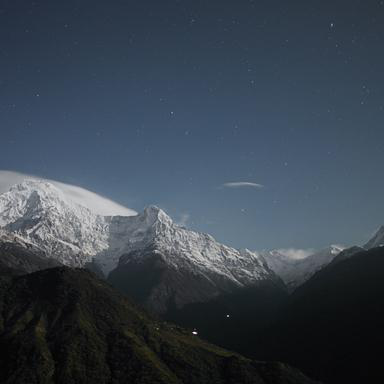

In [11]:
!wget https://picsum.photos/384 -O picsum.jpg
img = PIL.Image.open('picsum.jpg')
img

In [12]:
vt = OneClassVit()
input = torch.tensor(np.expand_dims(np.transpose(np.array(img) / 155 ), axis=0)).float()
logits = vt(input)
preds = logits.softmax(1)

In [13]:
for idx in preds.argsort(-1, descending=True)[0, :5]:
  print(idx)
  pred = preds[0, idx]
  label = imagenet_labels[idx.item()]
  print(f'{pred:.5f}: {label}', end='')

tensor(972)
0.69063: cliff, drop, drop-off
tensor(728)
0.18330: plastic_bag
tensor(979)
0.04699: valley, vale
tensor(976)
0.02643: promontory, headland, head, foreland
tensor(970)
0.02235: alp
